In [1]:
# These are the libraries will be used.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

from tqdm import tqdm
from dataSet import *
from unet_model import *
from torch.utils.data import DataLoader, random_split
from diceCoefficient import *

In [2]:
# Change these directories as needed

# Image Directories 
# image
dir_image='/home/matmatius/Desktop/otsuImages/originalrgb/'
# mask
dir_mask='/home/matmatius/Desktop/otsuImages/masksrgb/'
# scale image

In [3]:
dataset=Dataset(dir_image,dir_mask)
model=UNet(1,2, bilinear=False)
loss = nn.CrossEntropyLoss()

In [4]:
x=dataset[0]['image']
y=dataset[0]['mask']
print(x.shape,y.shape)

torch.Size([1, 128, 128]) torch.Size([1, 128, 128])


In [5]:
z=model(x.view(-1,1,128,128).float())
print(z.shape)

torch.Size([1, 2, 128, 128])


 split dataset

In [6]:
# Split dataset
val_percent=0.30

n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train_set, validation_dataset= random_split(dataset, [n_train, n_val])

In [7]:
# Augment Dataset
augmented=augmentData(train_set)

# create augmented dataset

train_dataset=augDateSet(augmented['image'],augmented['mask'])

100%|██████████| 83/83 [00:01<00:00, 77.74it/s]


In [8]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=5)
validation_loader=torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5)

In [9]:
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [10]:
torch.cuda.is_available()

True

In [17]:
n_epochs=8
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()
#n_epochs

#coeffcients
listS= []
listP = []

listDC = []

Loss=0
start_time = time.time()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device=device)

for epoch in range(n_epochs):
    print('epoch: '+str(epoch))
    
    for x in tqdm(train_loader):

        model.train() 
        #clear gradient optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        optimizer.zero_grad()
        #make a prediction 
        z = model(x['image'].view(-1,1,128,128).float().to(device))
        # calculate loss 
        loss = criterion(z, x['mask'][:,0].to(device))
        # calculate gradients of parameters 
        loss.backward()
        # update parameters 
        optimizer.step()
    loss_list.append(loss.data)
        
    correct=0
    for x in tqdm(validation_loader):
        y_test=x['mask'].to(device)
        # set model to eval 
        
        #make a prediction 
        z = model(x['image'].view(-1,1,128,128).float().to(device))
        #find max 
        _, yhat = torch.max(z.data, 1)
       
        #Calculate misclassified  samples in mini-batch 
        #hint +=(yhat==y_test).sum().item()
        
        correct += (yhat == y_test).sum().item()
        
        
        yhat=yhat.to('cpu').detach()[0]   
    
        #listS.append(sensitivity(yhat.numpy(), x['mask'][0].numpy()))
        #listP.append(precision(yhat.numpy(), x['mask'][0].numpy()))
        #listDC.append(diceCoef(yhat.numpy(), x['mask'][0].numpy()))
        
        
    accuracy=correct/(128*128*N_test*5)
    accuracy_list.append(accuracy)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 0


  1%|          | 1/100 [00:00<00:15,  6.43it/s]

epoch: 1


  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 2


  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 3


  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 4


  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 5


  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 6


  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 7


100%|██████████| 7/7 [00:00<00:00, 12.66it/s]


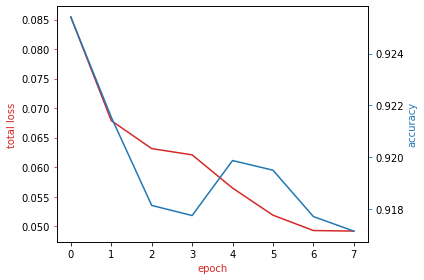

In [19]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [20]:
!pwd

/home/matmatius/Desktop/astrocyteSegmentation


In [16]:
#save model

#torch.save(model.state_dict(), '/home/matmatius/Desktop/astrocyteSegmentation/trainedUNet.pt')

model.load_state_dict(torch.load('/home/matmatius/Desktop/astrocyteSegmentation/trainedUNetNoBilinear.pt'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device=device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [17]:
def plotresult(x):
    z=model(x['image'].view(-1,1,128,128).float().to(device))
    _, yhat = torch.max(z.data, 1)
    yhat=yhat.to('cpu').detach()[0]
    fig, axs = plt.subplots(1, 3, figsize=(12, 12))
    axs[0].imshow(x['image'][0],cmap='gray')
    axs[0].set_title('input network')
    axs[1].imshow(x['mask'][0],cmap='gray')
    axs[1].set_title('ground truth')
    axs[2].imshow(yhat,cmap='gray')
    axs[2].set_title('network output') 
    plt.show()
    

In [18]:
len(validation_dataset)

35

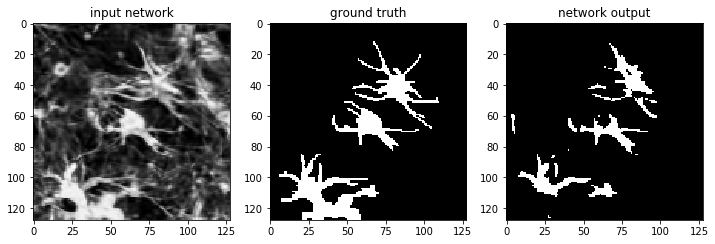

In [19]:
index=0
plotresult(validation_dataset[index])

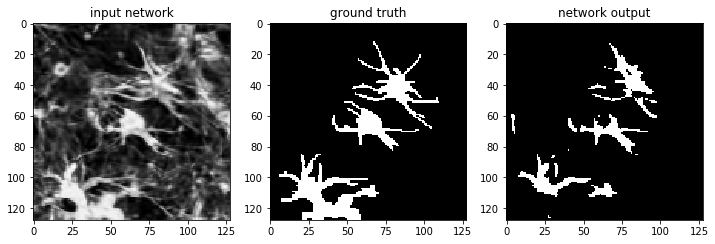

index =0
sensitivity = 0.5133333333333333
precision = 0.8599656357388317
dice coeffcient = 0.642903018625562


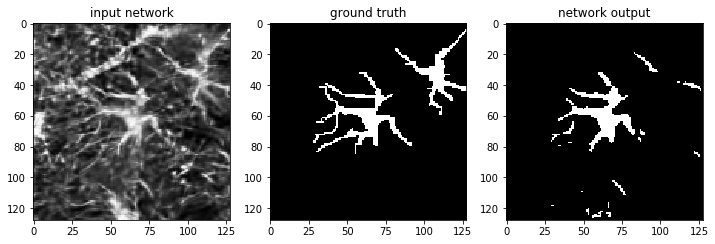

index =1
sensitivity = 0.5243798118049615
precision = 0.7521472392638037
dice coeffcient = 0.6179435483870968


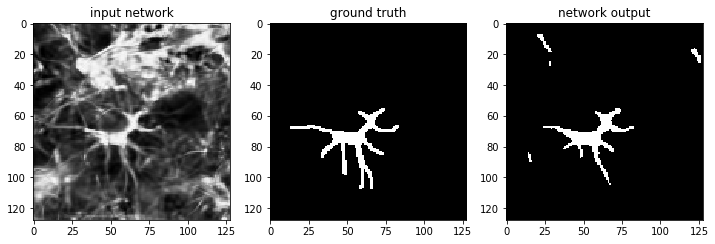

index =2
sensitivity = 0.6891271056661562
precision = 0.7627118644067796
dice coeffcient = 0.7240547063555913


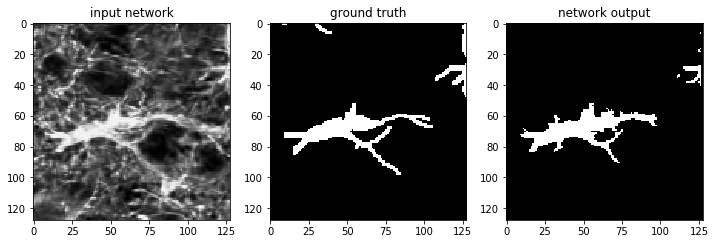

index =3
sensitivity = 0.7054794520547946
precision = 0.7907869481765835
dice coeffcient = 0.7457013574660634


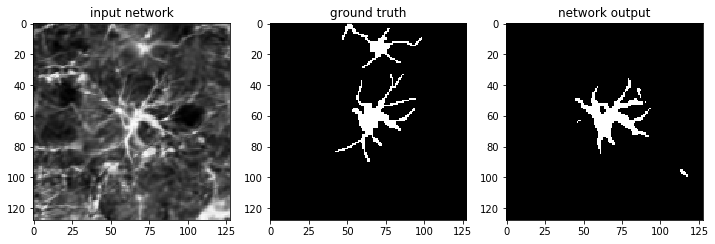

index =4
sensitivity = 0.5555555555555556
precision = 0.666131621187801
dice coeffcient = 0.6058394160583942


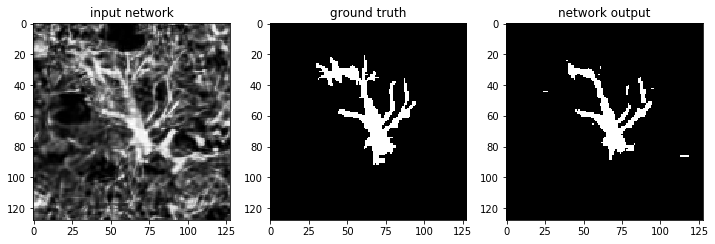

index =5
sensitivity = 0.6979553903345725
precision = 0.9340796019900498
dice coeffcient = 0.798936170212766


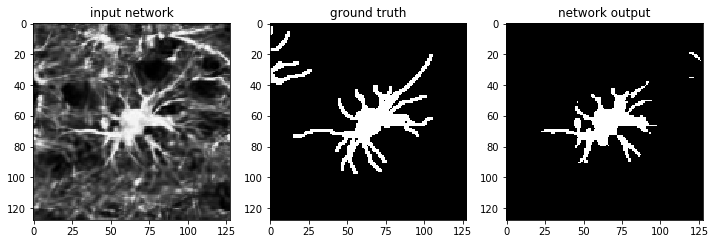

index =6
sensitivity = 0.5455140798952194
precision = 0.8142717497556208
dice coeffcient = 0.6533333333333333


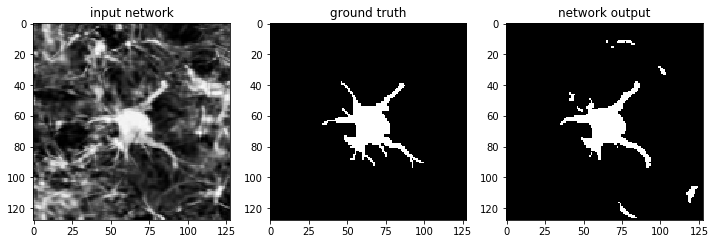

index =7
sensitivity = 0.8681564245810056
precision = 0.7920489296636085
dice coeffcient = 0.8283582089552238


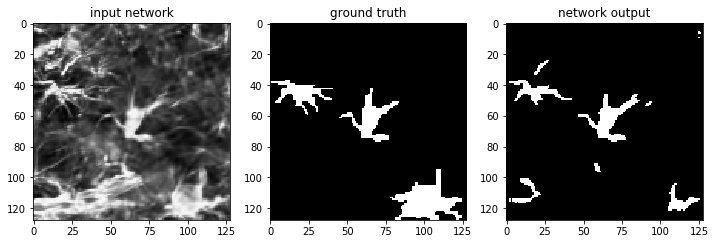

index =8
sensitivity = 0.48050036791758644
precision = 0.7575406032482599
dice coeffcient = 0.5880234128770824


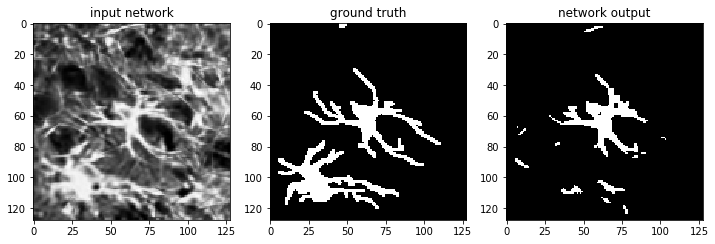

index =9
sensitivity = 0.4001006542526422
precision = 0.8502673796791443
dice coeffcient = 0.5441478439425051


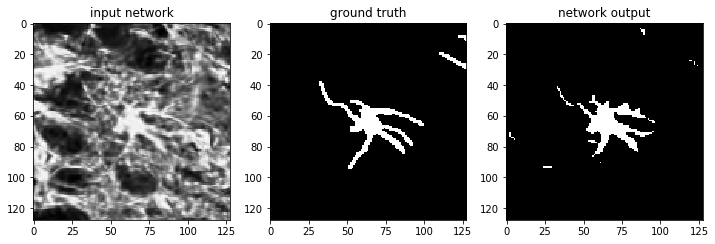

index =10
sensitivity = 0.7118863049095607
precision = 0.7804532577903682
dice coeffcient = 0.7445945945945946


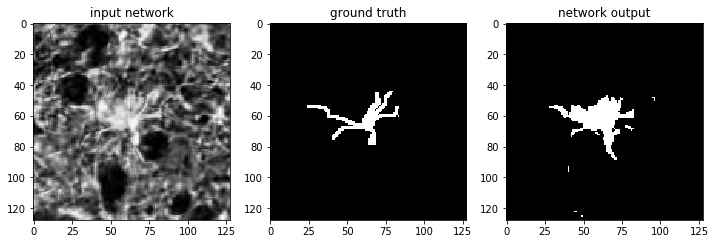

index =11
sensitivity = 0.8313817330210773
precision = 0.4863013698630137
dice coeffcient = 0.6136560069144339


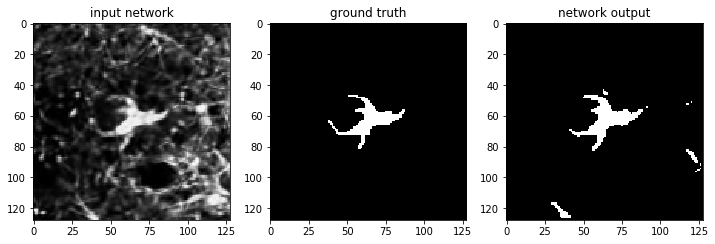

index =12
sensitivity = 0.9714964370546318
precision = 0.7100694444444444
dice coeffcient = 0.8204613841524574


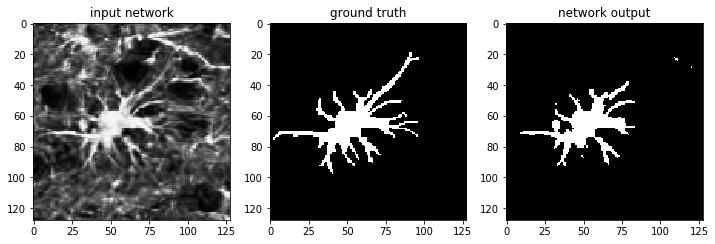

index =13
sensitivity = 0.7311248073959938
precision = 0.908133971291866
dice coeffcient = 0.8100725565514298


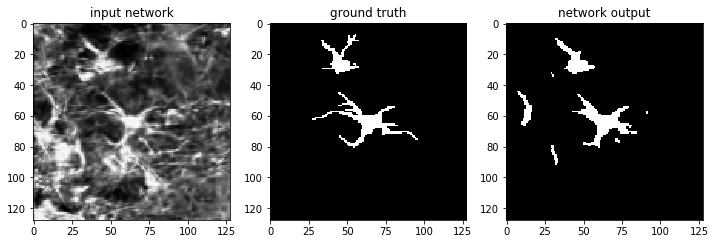

index =14
sensitivity = 0.8107667210440457
precision = 0.7019774011299436
dice coeffcient = 0.7524602573807722


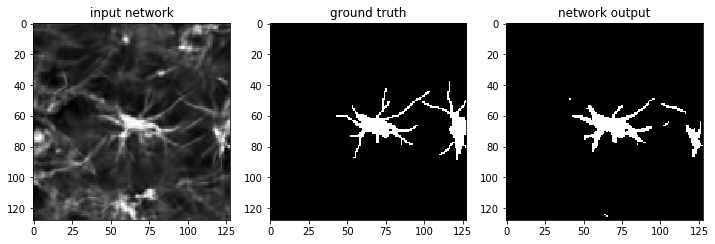

index =15
sensitivity = 0.6923076923076923
precision = 0.7808219178082192
dice coeffcient = 0.7339055793991416


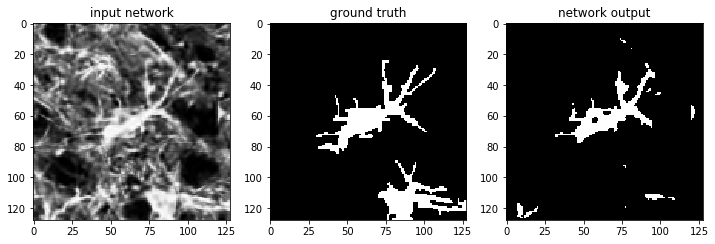

index =16
sensitivity = 0.4381231671554252
precision = 0.8199780461031834
dice coeffcient = 0.5711009174311926


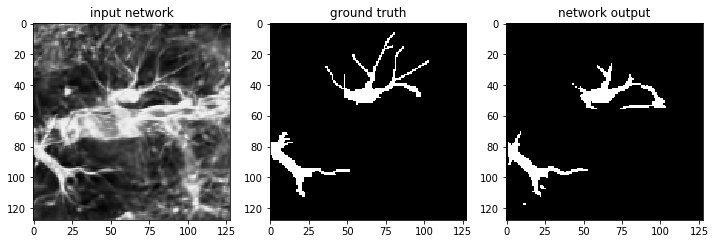

index =17
sensitivity = 0.7540045766590389
precision = 0.7987878787878788
dice coeffcient = 0.7757504414361389


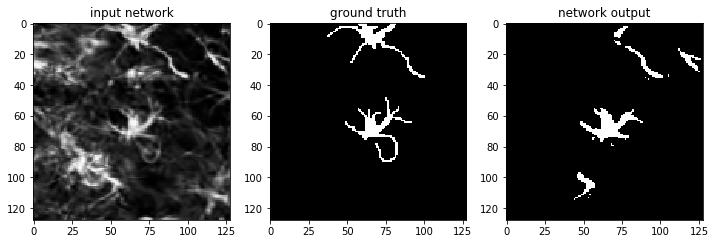

index =18
sensitivity = 0.5345911949685535
precision = 0.5733558178752108
dice coeffcient = 0.5532953620829943


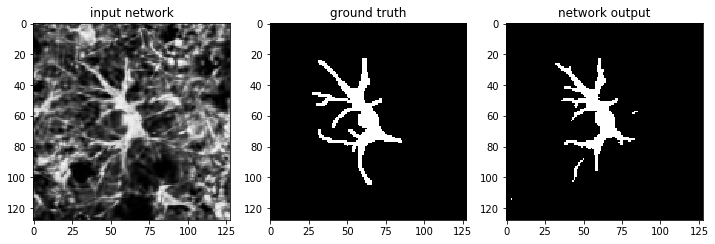

index =19
sensitivity = 0.7388282025819265
precision = 0.8532110091743119
dice coeffcient = 0.7919105907397552


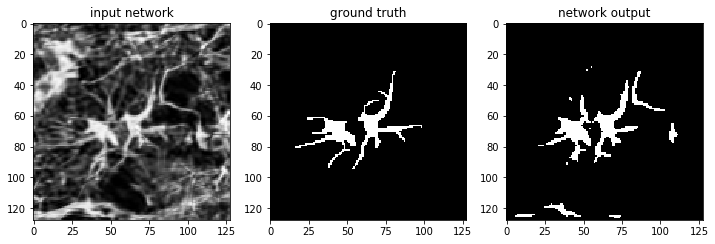

index =20
sensitivity = 0.7804195804195804
precision = 0.5699693564862104
dice coeffcient = 0.6587957497048406


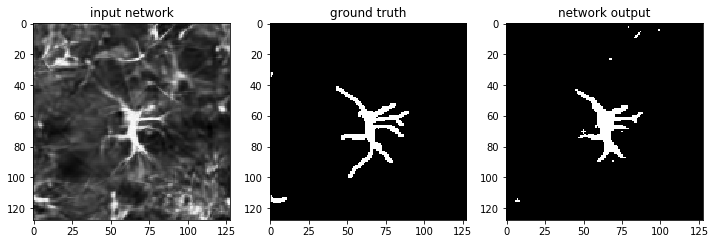

index =21
sensitivity = 0.6859903381642513
precision = 0.797752808988764
dice coeffcient = 0.7376623376623377


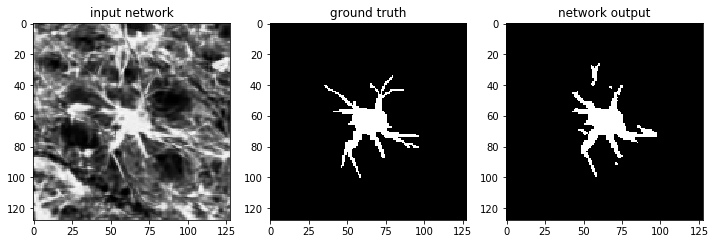

index =22
sensitivity = 0.8472049689440994
precision = 0.7976608187134503
dice coeffcient = 0.8216867469879519


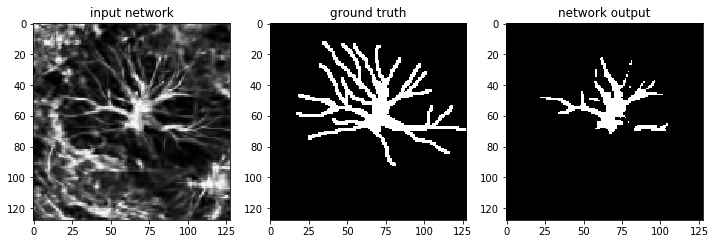

index =23
sensitivity = 0.3859275053304904
precision = 0.923469387755102
dice coeffcient = 0.544360902255639


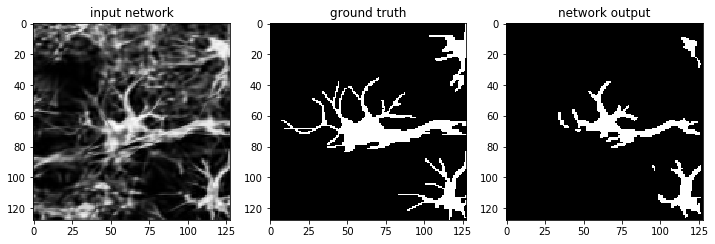

index =24
sensitivity = 0.5510411376333164
precision = 0.9140690817186183
dice coeffcient = 0.6875792141951838


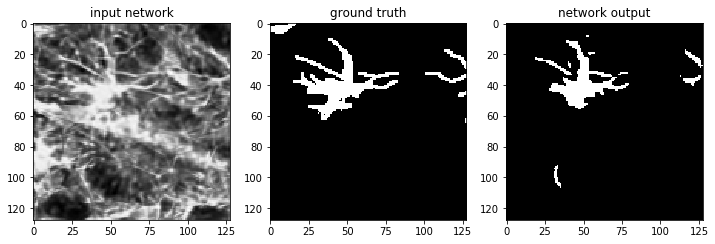

index =25
sensitivity = 0.5770212765957446
precision = 0.8329238329238329
dice coeffcient = 0.6817496229260935


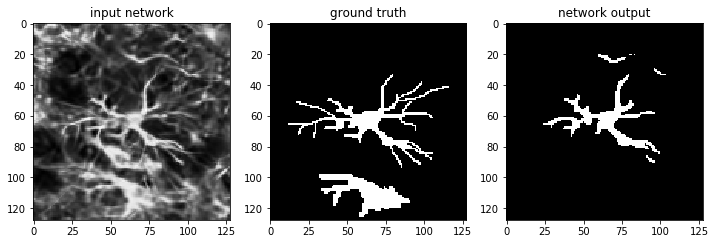

index =26
sensitivity = 0.3686837180286962
precision = 0.7705345501955672
dice coeffcient = 0.49873417721518987


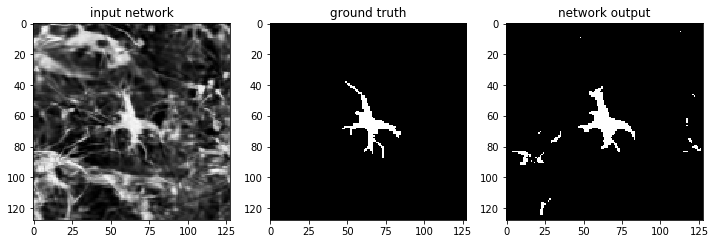

index =27
sensitivity = 0.886685552407932
precision = 0.5670289855072463
dice coeffcient = 0.6917127071823205


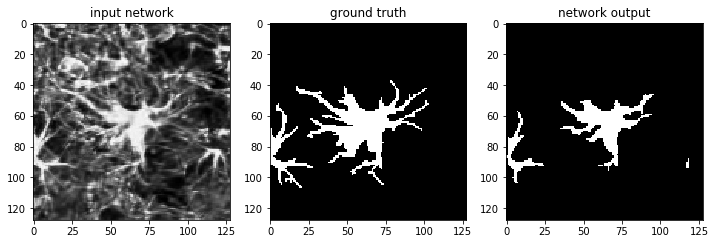

index =28
sensitivity = 0.5881346263548203
precision = 0.9493554327808471
dice coeffcient = 0.7263120817189151


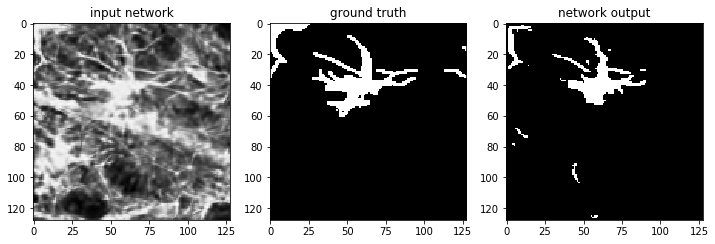

index =29
sensitivity = 0.5737051792828686
precision = 0.8421052631578947
dice coeffcient = 0.6824644549763034


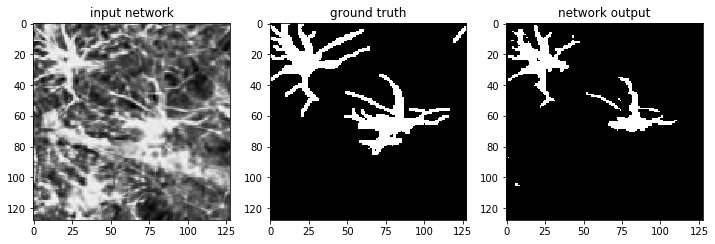

index =30
sensitivity = 0.519467718087728
precision = 0.9270008795074758
dice coeffcient = 0.6658243840808591


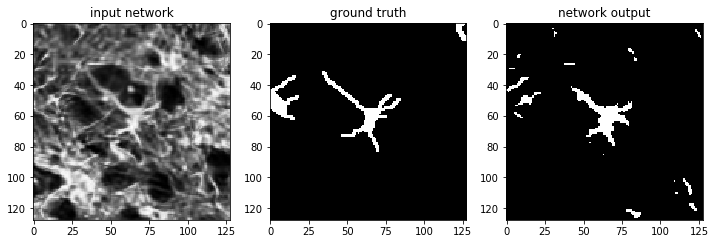

index =31
sensitivity = 0.5326251896813353
precision = 0.5716612377850163
dice coeffcient = 0.5514532600157109


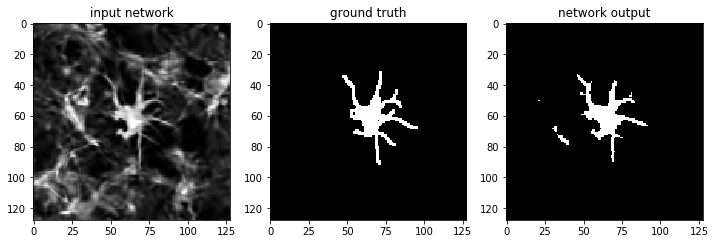

index =32
sensitivity = 0.750373692077728
precision = 0.8243021346469622
dice coeffcient = 0.7856025039123631


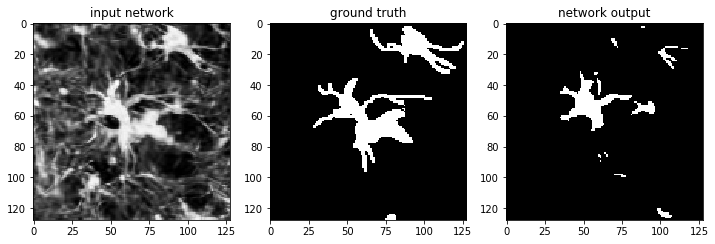

index =33
sensitivity = 0.2981260647359455
precision = 0.7065948855989233
dice coeffcient = 0.4193290734824281


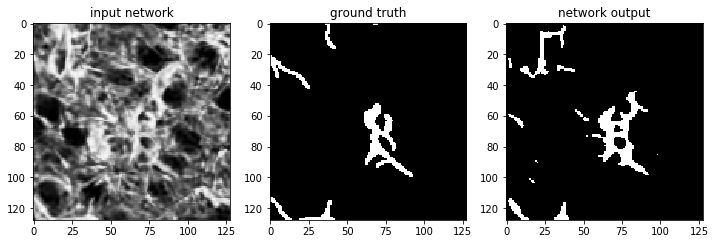

index =34
sensitivity = 0.6851612903225807
precision = 0.5100864553314121
dice coeffcient = 0.5848017621145375


In [20]:
for index in range(len(validation_dataset)):
    plotresult(validation_dataset[index])
    x=validation_dataset[index]
    z=z=model(x['image'].view(-1,1,128,128).float().to(device))
    _, yhat = torch.max(z.data, 1)
    
    
    yhat=yhat.to('cpu').detach()[0]
    print('index ='+str(index))
    
    print('sensitivity = '+str(sensitivity(yhat.numpy(), x['mask'][0].numpy())))
    print('precision = '+ str(precision(yhat.numpy(), x['mask'][0].numpy())))
    print('dice coeffcient = '+ str(diceCoef(yhat.numpy(), x['mask'][0].numpy())))
    
    

In [21]:
index=0
x=validation_dataset[index]
z=z=model(x['image'].view(-1,1,128,128).float().to(device))
_, yhat = torch.max(z.data, 1)
yhat=yhat.to('cpu').detach()[0]
#yhat=yhat.numpy()

#truePos(pred_labels, true_labels)
print('computed by method')
print('True Positive: '+str(truePos(yhat.numpy(), x['mask'].numpy())))
print('Dice Coefficent: ' +str(diceCoef(yhat.numpy(), x['mask'][0].numpy())))
print('computed with other method')
TP=(yhat*x['mask'][0]).sum().item()
DC=2*(yhat*x['mask'][0]).sum().item()/(yhat.sum().item()+x['mask'][0].sum().item())
print("TP: "+str(TP))
print("DC: "+ str(DC))

computed by method
True Positive: 1001
Dice Coefficent: 0.642903018625562
computed with other method
TP: 1001
DC: 0.642903018625562


In [22]:
listSv= []
listPv = []

listDCv = []

for index in range(len(validation_dataset)):
    x=validation_dataset[index]
    z=model(x['image'].view(-1,1,128,128).float().to(device))
    _, yhat = torch.max(z.data, 1)
    yhat=yhat.to('cpu').detach()[0]
    
    
    listSv.append(sensitivity(yhat.numpy(), x['mask'][0].numpy()))
    listPv.append(precision(yhat.numpy(), x['mask'][0].numpy()))
    listDCv.append(diceCoef(yhat.numpy(), x['mask'][0].numpy()))

    
listSt= []
listPt = []

listDCt = []

for index in range(len(train_dataset)):
    x=train_dataset[index]
    z=model(x['image'].view(-1,1,128,128).float().to(device))
    _, yhat = torch.max(z.data, 1)
    yhat=yhat.to('cpu').detach()[0]
    
    
    listSt.append(sensitivity(yhat.numpy(), x['mask'][0].numpy()))
    listPt.append(precision(yhat.numpy(), x['mask'][0].numpy()))
    listDCt.append(diceCoef(yhat.numpy(), x['mask'][0].numpy()))
    
    

Validation Dataset
sensitivity:  mean=0.6350051671588826, std=0.16001138956105582
precision:  mean=0.768501622813607, std=0.12181919733265124
dice coeffcient:  mean=0.67584336243792, std=0.10218872868872077


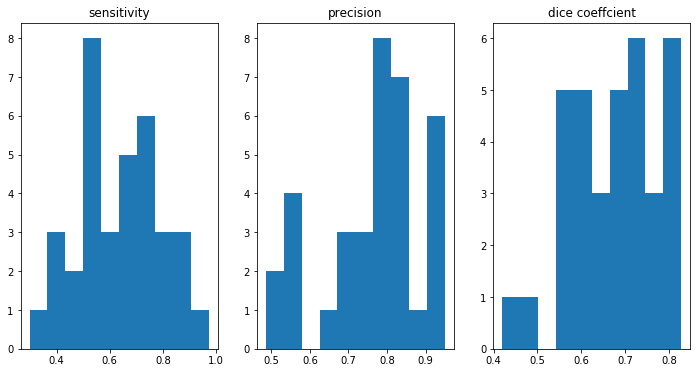

Train Dataset
sensitivity:  mean=0.6119907994096062, std=0.1471548341982446
precision:  mean=0.7209017702896925, std=0.1483964364926001
dice coeffcient:  mean=0.6421235258192234, std=0.10899397467431872


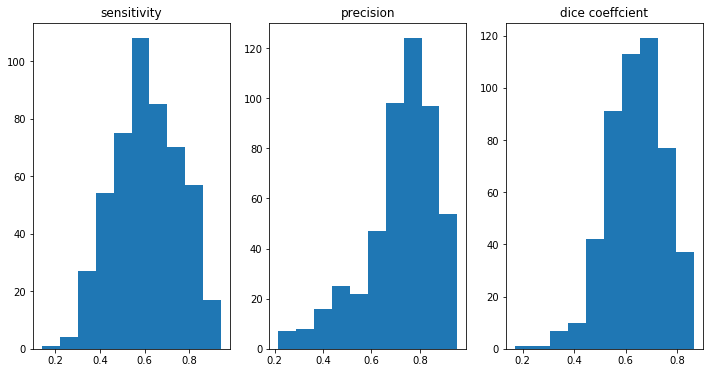

In [23]:
#plot coeffcients

print('Validation Dataset')
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].hist(listSv)
axs[0].set_title('sensitivity')
print('sensitivity:  mean='+ str(np.mean(listSv))+', std='+str(np.std(listSv)))
axs[1].hist(listPv)
axs[1].set_title('precision')
print('precision:  mean='+ str(np.mean(listPv))+', std='+str(np.std(listPv)))
axs[2].hist(listDCv)
axs[2].set_title('dice coeffcient')
print('dice coeffcient:  mean='+ str(np.mean(listDCv))+', std='+str(np.std(listDCv)))
plt.show()


print('Train Dataset')
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].hist(listSt)
axs[0].set_title('sensitivity')
print('sensitivity:  mean='+ str(np.mean(listSt))+', std='+str(np.std(listSt)))
axs[1].hist(listPt)
axs[1].set_title('precision')
print('precision:  mean='+ str(np.mean(listPt))+', std='+str(np.std(listPt)))
axs[2].hist(listDCt)
axs[2].set_title('dice coeffcient')
print('dice coeffcient:  mean='+ str(np.mean(listDCt))+', std='+str(np.std(listDCt)))
plt.show()


# Histograms of each instance output, each pixel. 128 x128 x2

In [24]:
def plotHistInst(index1,index2):

    #index1=65
    #index2=65

    channel_black_v=[]
    channel_white_v=[]
    channel_black_t=[]
    channel_white_t=[]

    for index in range(len(train_dataset)):
        x=train_dataset[index]
        z=model(x['image'].view(-1,1,128,128).float().to(device)).to('cpu').detach()
        channel_black_t.append(z[0,0,index1,index2].item())
        channel_white_t.append(z[0,1,index1,index2].item())

    for index in range(len(validation_dataset)):
        x=validation_dataset[index]
        z=model(x['image'].view(-1,1,128,128).float().to(device)).to('cpu').detach()
        channel_black_v.append(z[0,0,index1,index2].item())
        channel_white_v.append(z[0,1,index1,index2].item())
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    print("pixel: ("+str(index1)+' , '+str(index2)+")")
    axs[0].hist(channel_black_t)
    axs[0].set_xlabel('raw value')
    axs[0].set_ylabel('frequencies')
    axs[0].set_title('black output, train data')
    axs[1].hist(channel_white_t)
    axs[1].set_xlabel('raw value')
    axs[1].set_ylabel('frequencies')
    axs[1].set_title('white output, train data')
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].hist(channel_black_v)
    axs[0].set_xlabel('raw value')
    axs[0].set_ylabel('frequencies')
    axs[0].set_title('black output, validation data')
    axs[1].hist(channel_white_v)
    axs[1].set_xlabel('raw value')
    axs[1].set_ylabel('frequencies')
    axs[1].set_title('white output, validation data')

pixel: (8 , 120)


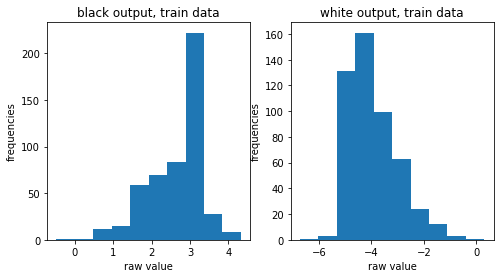

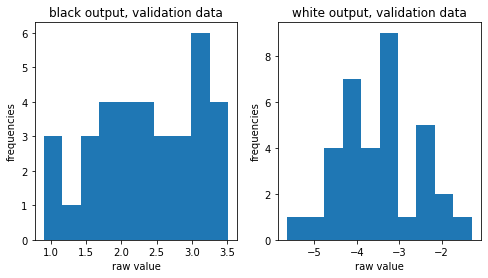

In [25]:
plotHistInst(8,120)

pixel: (20 , 32)


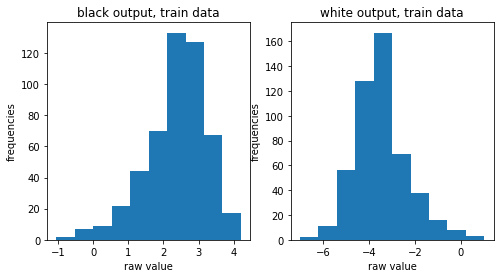

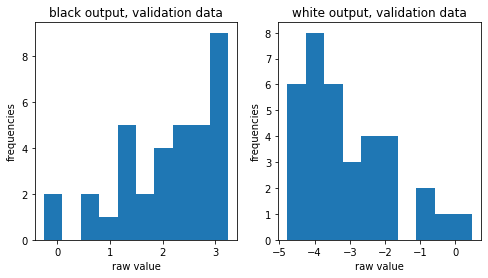

In [26]:
plotHistInst(20,32)

pixel: (58 , 44)


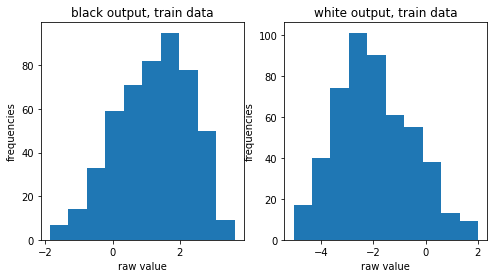

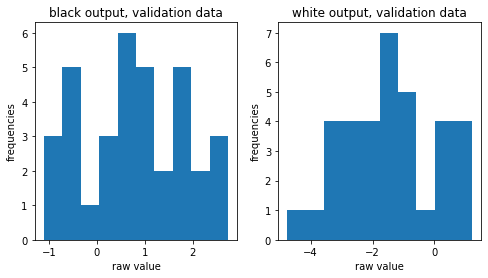

In [27]:
plotHistInst(58,44)

pixel: (65 , 65)


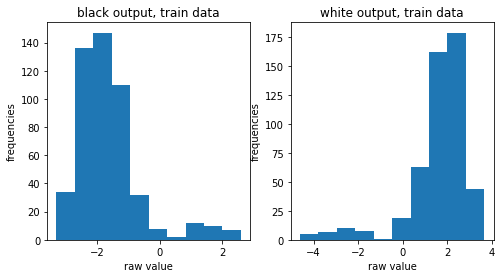

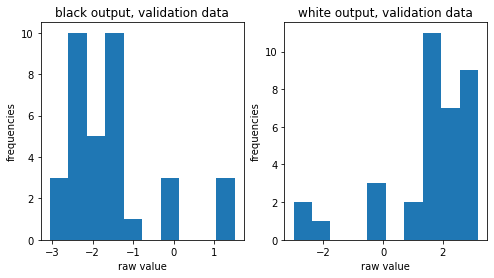

In [28]:
plotHistInst(65,65)

pixel: (24 , 32)


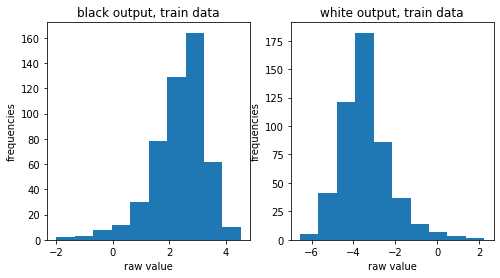

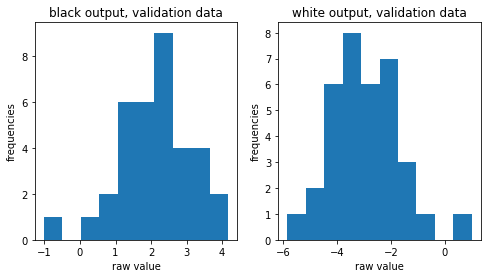

In [29]:
plotHistInst(24,32)

pixel: (23 , 80)


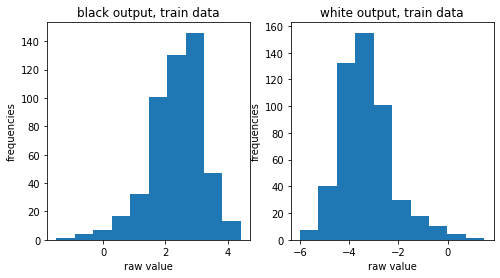

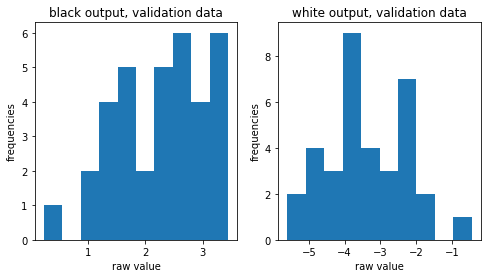

In [30]:
plotHistInst(23,80)

pixel: (96 , 23)


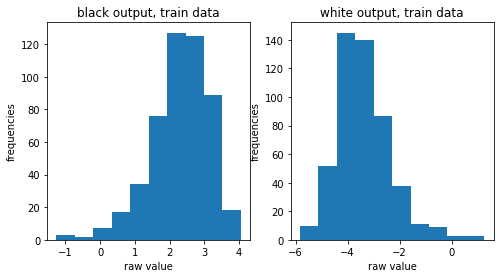

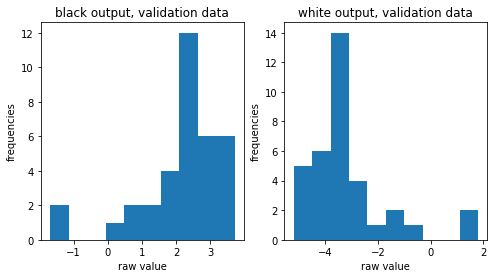

In [31]:
plotHistInst(96,23)